In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import mdn

Using TensorFlow backend.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 88200
overlap = 22050

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        SR = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_category)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [11]:
c_data, targets, c_targets = load_fold_audio_blockwise(1, dataset, blocksize, overlap)
# c_data, targets = load_fold_audio(1, dataset)
print(c_data.shape)

	Processing Time: 2.297299861907959
(1126, 1, 88200)


In [12]:
a_data = c_data[targets == 0]
a_targ = c_targets[targets == 0]
i_data = c_data[targets == 1]
i_targ = c_targets[targets == 1]

In [13]:
names_a = []
for name in np.unique(a_targ):
    names_a.append(classes[name])
names_i = []
for name in np.unique(i_targ):
    names_i.append(classes[name])
print(names_a)
print(names_i)

['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'crickets', 'chirping_birds', 'crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing', 'laughing', 'snoring']
['rain', 'sea_waves', 'crackling_fire', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm', 'footsteps', 'brushing_teeth', 'drinking_sipping', 'door_wood_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking', 'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw']


In [14]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        c_data, targets, test_size=0.20, random_state=42)

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    display.specshow(result, y_axis='linear', fmin=800, fmax=8000, sr=SR)
    plt.show()
    
def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
#     result = np.swapaxes(result, 1, 2)
    print(result.shape)
    return result

________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_1 (Melspec (None, 128, 345, 1)       296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 5s 2s/step - loss: 1439.3304
(1, 88200)


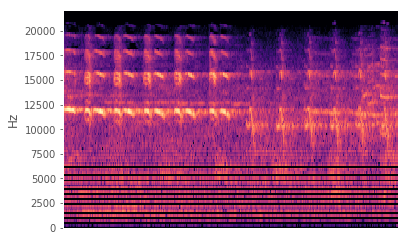

(1126, 128, 345)
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
spectrogram_1 (Spectrogra (None, 257, 345, 1)       263168      
Total params: 263,168
Trainable params: 0
Non-trainable params: 263,168
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 79ms/step - loss: 1185.2368
(1, 88200)


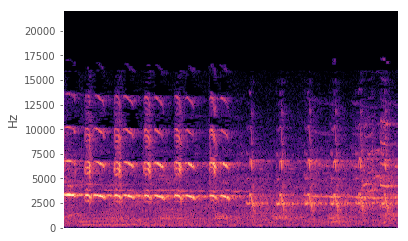

(1126, 257, 345)


In [16]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
import numpy as np

model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False
))

check_model(model)
visualise_model(model, c_data[1])
mfccs = evaluate_model(model, c_data)

model = Sequential()
model.add(Spectrogram(
    return_decibel_spectrogram = True,
    input_shape=(1, blocksize)
))

check_model(model)
visualise_model(model, c_data[1])
spec = evaluate_model(model, c_data)

# Deep Net
Separate into classes

In [17]:
import librosa

def preprocess(mel_spec, spec):
    # Calculate the first 13 mfcc's
    mfccs = librosa.feature.mfcc(S=mel_spec, n_mfcc=13)
    # Get first derivative of the mfccs
    delta = librosa.feature.delta(mfccs)
    # Get second derivative of mfccs
    delta_2 = librosa.feature.delta(mfccs, order=2)
    
    spec_contrast = librosa.feature.spectral_contrast(S=spec)
    
    return np.vstack((mfccs[1:], delta, delta_2, spec_contrast)).transpose()

In [18]:
a_mfcc = mfccs[targets == 0]
a_spec = spec[targets == 0]
a_targ = c_targets[targets == 0]
i_mfcc = mfccs[targets == 1]
i_spec = spec[targets == 1]
i_targ = c_targets[targets == 1]

In [19]:
start_time = time.time()

new_dat = []
for i in range(0, a_spec.shape[0]):
    new_dat.append(preprocess(a_mfcc[i], a_spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

(345, 45)
	Processing Time: 4.59581732749939


In [22]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(422, 45)


In [23]:
new_dat = np.vstack(new_dat)
print(new_dat.shape)

(422, 45)


In [24]:
print(a_targ.shape)

(422,)


# Animal Sounds

In [25]:
train_X, test_X, train_y, test_y = train_test_split(
                        new_dat, a_targ, test_size=0.20, random_state=56)

In [26]:
from keras.layers import Dense, Dropout

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(45,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(19, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [30]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=200, 
                       batch_size=128, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 128)               5888      
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
__________

Epoch 49/200
286/286 [==============================] - 0s 102us/step - loss: 1.6740 - acc: 0.4371 - val_loss: 1.3891 - val_acc: 0.6275
Epoch 50/200
286/286 [==============================] - 0s 105us/step - loss: 1.6412 - acc: 0.4895 - val_loss: 1.3939 - val_acc: 0.6078
Epoch 51/200
286/286 [==============================] - 0s 103us/step - loss: 1.6270 - acc: 0.4790 - val_loss: 1.4214 - val_acc: 0.5882
Epoch 52/200
286/286 [==============================] - 0s 102us/step - loss: 1.6797 - acc: 0.4825 - val_loss: 1.4219 - val_acc: 0.5882
Epoch 53/200
286/286 [==============================] - 0s 101us/step - loss: 1.5698 - acc: 0.4860 - val_loss: 1.3780 - val_acc: 0.6078
Epoch 54/200
286/286 [==============================] - 0s 105us/step - loss: 1.6365 - acc: 0.4720 - val_loss: 1.3417 - val_acc: 0.6078
Epoch 55/200
286/286 [==============================] - 0s 279us/step - loss: 1.7109 - acc: 0.4231 - val_loss: 1.3126 - val_acc: 0.6275
Epoch 56/200
286/286 [==========================

286/286 [==============================] - 0s 101us/step - loss: 0.9240 - acc: 0.7098 - val_loss: 0.9979 - val_acc: 0.7255
Epoch 110/200
286/286 [==============================] - 0s 101us/step - loss: 0.9271 - acc: 0.6923 - val_loss: 0.9814 - val_acc: 0.7255
Epoch 111/200
286/286 [==============================] - 0s 102us/step - loss: 0.9432 - acc: 0.6573 - val_loss: 0.9773 - val_acc: 0.7451
Epoch 112/200
286/286 [==============================] - 0s 105us/step - loss: 0.8959 - acc: 0.6958 - val_loss: 0.9938 - val_acc: 0.7647
Epoch 113/200
286/286 [==============================] - 0s 109us/step - loss: 0.9190 - acc: 0.6958 - val_loss: 1.0323 - val_acc: 0.7255
Epoch 114/200
286/286 [==============================] - 0s 101us/step - loss: 0.8770 - acc: 0.7098 - val_loss: 1.0344 - val_acc: 0.7255
Epoch 115/200
286/286 [==============================] - 0s 104us/step - loss: 0.9313 - acc: 0.7098 - val_loss: 0.9974 - val_acc: 0.7451
Epoch 116/200
286/286 [==============================] 

286/286 [==============================] - 0s 110us/step - loss: 0.5974 - acc: 0.8007 - val_loss: 0.8563 - val_acc: 0.7843
Epoch 170/200
286/286 [==============================] - 0s 103us/step - loss: 0.5746 - acc: 0.8042 - val_loss: 0.8277 - val_acc: 0.7843
Epoch 171/200
286/286 [==============================] - 0s 104us/step - loss: 0.5004 - acc: 0.8357 - val_loss: 0.8430 - val_acc: 0.7647
Epoch 172/200
286/286 [==============================] - 0s 102us/step - loss: 0.6278 - acc: 0.8007 - val_loss: 0.8814 - val_acc: 0.7451
Epoch 173/200
286/286 [==============================] - 0s 95us/step - loss: 0.6090 - acc: 0.7692 - val_loss: 0.8762 - val_acc: 0.7843
Epoch 174/200
286/286 [==============================] - 0s 105us/step - loss: 0.5573 - acc: 0.8182 - val_loss: 0.8874 - val_acc: 0.7843
Epoch 175/200
286/286 [==============================] - 0s 103us/step - loss: 0.5516 - acc: 0.8042 - val_loss: 0.8976 - val_acc: 0.7843
Epoch 176/200
286/286 [==============================] -

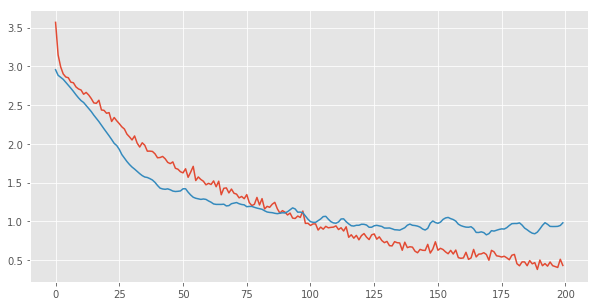

In [31]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

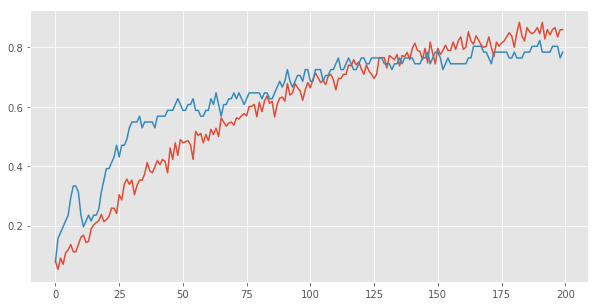

In [32]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.7529411764705882
Confusion matrix, without normalization
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0]
 [0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 4 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 5 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 3 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 1 6]]


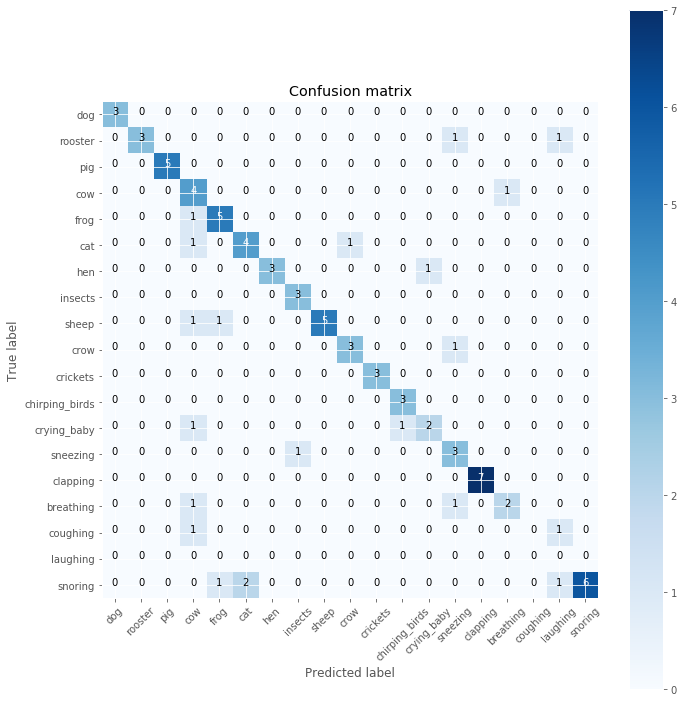

In [33]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

# Interacting Materials

In [35]:
start_time = time.time()

new_dat = []
for i in range(0, i_spec.shape[0]):
    new_dat.append(preprocess(i_mfcc[i], i_spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

(345, 45)
	Processing Time: 7.453464508056641


In [36]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(704, 45)


In [37]:
print(i_targ.shape)

(704,)


In [39]:
train_X, test_X, train_y, test_y = train_test_split(
                        new_dat, i_targ, test_size=0.20, random_state=75)

In [40]:
def gpu_mfcc_deep_net_i():
    # Create Model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(45,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(31, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [42]:
inter = KerasClassifier(build_fn=gpu_mfcc_deep_net_i, epochs=200, batch_size=128, validation_split=0.15)
history = inter.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 128)               5888      
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_34 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
__________

478/478 [==============================] - 0s 101us/step - loss: 1.8800 - acc: 0.4100 - val_loss: 1.9530 - val_acc: 0.3765
Epoch 50/200
478/478 [==============================] - 0s 86us/step - loss: 1.8365 - acc: 0.3912 - val_loss: 1.9537 - val_acc: 0.3882
Epoch 51/200
478/478 [==============================] - 0s 75us/step - loss: 1.8295 - acc: 0.4310 - val_loss: 1.9526 - val_acc: 0.3647
Epoch 52/200
478/478 [==============================] - 0s 90us/step - loss: 1.7752 - acc: 0.4163 - val_loss: 1.9305 - val_acc: 0.4118
Epoch 53/200
478/478 [==============================] - 0s 78us/step - loss: 1.8081 - acc: 0.3912 - val_loss: 1.9142 - val_acc: 0.3882
Epoch 54/200
478/478 [==============================] - 0s 80us/step - loss: 1.7346 - acc: 0.4393 - val_loss: 1.9125 - val_acc: 0.3765
Epoch 55/200
478/478 [==============================] - 0s 82us/step - loss: 1.7123 - acc: 0.4561 - val_loss: 1.8966 - val_acc: 0.4118
Epoch 56/200
478/478 [==============================] - 0s 85us/ste

478/478 [==============================] - 0s 175us/step - loss: 1.1275 - acc: 0.6423 - val_loss: 1.7208 - val_acc: 0.5882
Epoch 110/200
478/478 [==============================] - 0s 78us/step - loss: 1.1269 - acc: 0.6234 - val_loss: 1.7118 - val_acc: 0.6471
Epoch 111/200
478/478 [==============================] - 0s 87us/step - loss: 1.1016 - acc: 0.6360 - val_loss: 1.7239 - val_acc: 0.5412
Epoch 112/200
478/478 [==============================] - 0s 80us/step - loss: 1.0936 - acc: 0.6339 - val_loss: 1.7343 - val_acc: 0.5765
Epoch 113/200
478/478 [==============================] - 0s 82us/step - loss: 1.0709 - acc: 0.6527 - val_loss: 1.7735 - val_acc: 0.5294
Epoch 114/200
478/478 [==============================] - 0s 79us/step - loss: 1.1043 - acc: 0.6088 - val_loss: 1.8091 - val_acc: 0.5294
Epoch 115/200
478/478 [==============================] - 0s 85us/step - loss: 1.1628 - acc: 0.6234 - val_loss: 1.7298 - val_acc: 0.5882
Epoch 116/200
478/478 [==============================] - 0s 8

478/478 [==============================] - 0s 81us/step - loss: 0.7644 - acc: 0.7531 - val_loss: 1.5801 - val_acc: 0.6588
Epoch 170/200
478/478 [==============================] - 0s 88us/step - loss: 0.7281 - acc: 0.7720 - val_loss: 1.6237 - val_acc: 0.6471
Epoch 171/200
478/478 [==============================] - 0s 90us/step - loss: 0.7626 - acc: 0.7259 - val_loss: 1.6381 - val_acc: 0.6000
Epoch 172/200
478/478 [==============================] - 0s 81us/step - loss: 0.7569 - acc: 0.7531 - val_loss: 1.6492 - val_acc: 0.6471
Epoch 173/200
478/478 [==============================] - 0s 79us/step - loss: 0.7626 - acc: 0.7385 - val_loss: 1.6205 - val_acc: 0.6471
Epoch 174/200
478/478 [==============================] - 0s 99us/step - loss: 0.7498 - acc: 0.7406 - val_loss: 1.5855 - val_acc: 0.6706
Epoch 175/200
478/478 [==============================] - 0s 81us/step - loss: 0.7288 - acc: 0.7615 - val_loss: 1.5712 - val_acc: 0.6706
Epoch 176/200
478/478 [==============================] - 0s 82

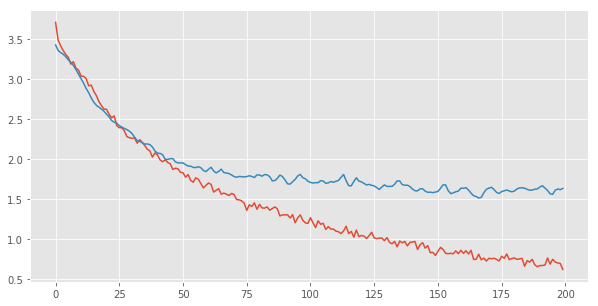

In [43]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

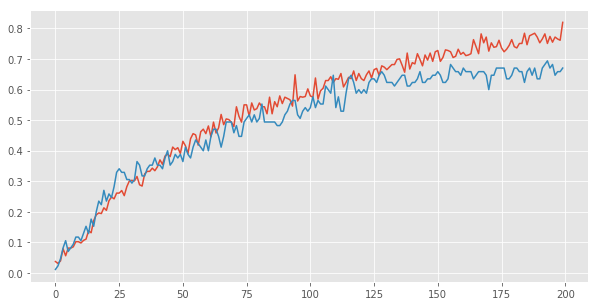

In [44]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.7021276595744681
Confusion matrix, without normalization
[[9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 3 0]
 [0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 3

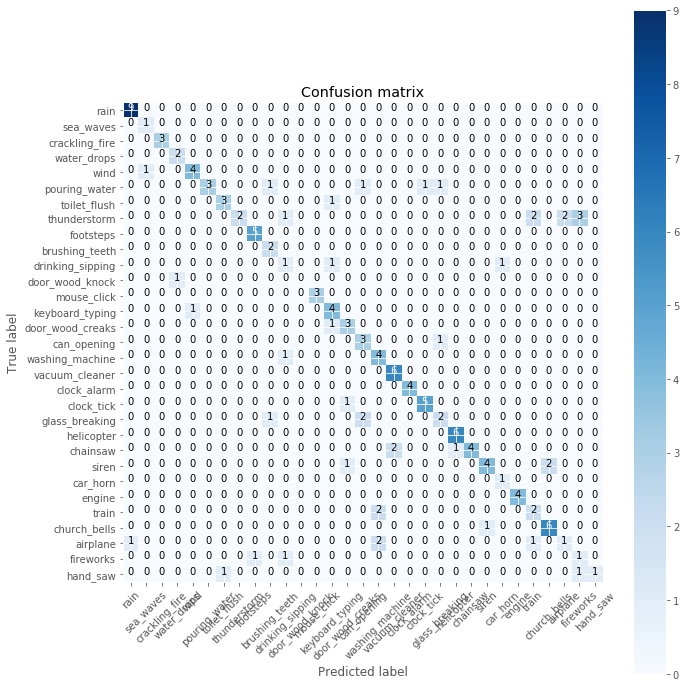

In [45]:
pred = inter.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

# All Data

In [46]:
X2, y2, yy2 = load_fold_audio_blockwise(2, dataset, blocksize, overlap)
X3, y3, yy3 = load_fold_audio_blockwise(3, dataset, blocksize, overlap)
X4, y4, yy4 = load_fold_audio_blockwise(4, dataset, blocksize, overlap)
X5, y5, yy5 = load_fold_audio_blockwise(5, dataset, blocksize, overlap)

	Processing Time: 2.361219644546509
	Processing Time: 2.674727201461792
	Processing Time: 2.329937219619751
	Processing Time: 2.4029417037963867


In [47]:
X = np.vstack((X2, X3, X4, X5))
print(X.shape)

(4538, 1, 88200)


In [48]:
y = np.concatenate((y2, y3, y4, y5))
print(y.shape)

(4538,)


In [49]:
yy = np.concatenate((yy2, yy3, yy4, yy5))
print(yy.shape)

(4538,)


________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_2 (Melspec (None, 128, 345, 1)       296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 1s 618ms/step - loss: 1430.0721
(1, 88200)


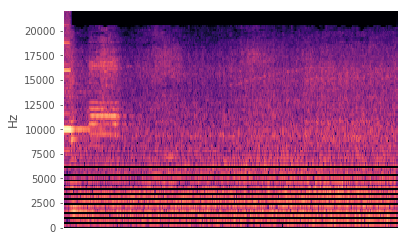

(4538, 128, 345)
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
spectrogram_2 (Spectrogra (None, 257, 345, 1)       263168      
Total params: 263,168
Trainable params: 0
Non-trainable params: 263,168
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 2s 800ms/step - loss: 1175.7290
(1, 88200)


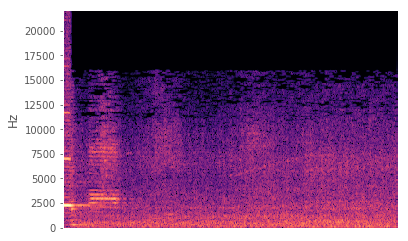

(4538, 257, 345)


In [50]:
model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False
))

check_model(model)
visualise_model(model, X[1])
mfccs = evaluate_model(model, X)

model = Sequential()
model.add(Spectrogram(
    return_decibel_spectrogram = True,
    input_shape=(1, blocksize)
))

check_model(model)
visualise_model(model, X[1])
spec = evaluate_model(model, X)

In [52]:
a_mfcc = mfccs[y == 0]
a_spec = spec[y == 0]
a_targ = yy[y == 0]
i_mfcc = mfccs[y == 1]
i_spec = spec[y == 1]
i_targ = yy[y == 1]

In [53]:
start_time = time.time()

new_dat = []
for i in range(0, a_spec.shape[0]):
    new_dat.append(preprocess(a_mfcc[i], a_spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

start_time = time.time()

(345, 45)
	Processing Time: 19.560091495513916


In [54]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(1709, 45)


In [55]:
print(a_targ.shape)

(1709,)


0.30017554125219426
Confusion matrix, without normalization
[[57  0  0  7  0  2  7  1  1  4  0  0  1  6  4  0  0  1  0]
 [10 35  0  1  3  0  3  1  2 10  1  2  1  7  3  0  2  4  0]
 [ 0  1 29  2  0  5  4  9  0  7  0  6  4  1  1  4  2  3  9]
 [29  0  3 15  2 12  9  2  5  0  0  0  1  3  0  6  2  1  1]
 [ 5  7  0 10 30 15  0  0  2  7  0  8  0  0  5  1  0  6  0]
 [14  1  5  7 11  9  4  0  3 10  0  1  2  1  2  1  3  9  0]
 [ 7  1  5  8  0  1 37  8  0  0  8  0  3  3  2  4  1  1  2]
 [18  0  6  7  0  4  0 32  0  0 12  3  1  1  0  0  1  6  3]
 [10  9  7  0  8 15  4  0 29  3  0  2  2  1  4  0  2  0  0]
 [ 7  1  0 13 23  5  6  1  0 25  0  0  0  0  8  1  0  0  1]
 [ 6  0  0  2  3  1  0  6  3  0 29 31  3  6  0  0  0  0  6]
 [ 6  1  4  5  1  5  2  0  4  3  2 46  4  0  0  1  0  0 12]
 [ 3 11  0  1  0  3  1  2  2  6  1 20 17 10 16  0  2  0  0]
 [ 0  0  2  7  1  0  1  6  2  1  0  8  0 35  0  0 10  4  2]
 [ 4  1 10  7  2  0  0  0  1 13  0  1  0  2 47  1  2  2  1]
 [ 4  5  4  6 16  5  7  0  0  5  0  1  1

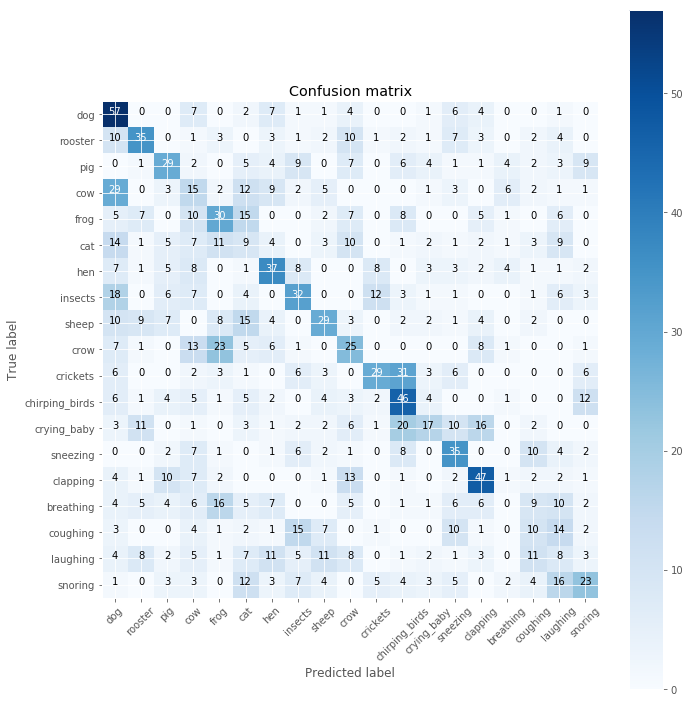

In [57]:
pred = anim.predict(new_dat)
print(metrics.accuracy_score(a_targ, pred))
cm = metrics.confusion_matrix(a_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

In [58]:
start_time = time.time()

new_dat = []
for i in range(0, i_spec.shape[0]):
    new_dat.append(preprocess(i_mfcc[i], i_spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

start_time = time.time()

(345, 45)
	Processing Time: 32.769745111465454


In [59]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(2829, 45)


In [60]:
print(i_targ.shape)

(2829,)


0.19052668787557442
Confusion matrix, without normalization
[[13  7  0  0  3  0 10  0  3  4  0  0  0  0  8  0  9  3  0  0  2  6  6  0
   3  6  3  0  3  0  7]
 [ 0 35  0  0  8  1 12  0  0  0  0  0  0  1  0  0  1  2  0  0  1  2 17  0
   2  1  0  3  1  0  9]
 [ 0  0 23  4  4  0  0  0  0  0  3  3 20 12  1  2  3  0  2  3  3  0  0  0
   0  8  1  0  0  3  0]
 [ 0  0  1  9  0  1  0  0  1  1  7  0 18  3  2 10  0  0  0  8  7  1  0  2
   0  3  0  1  0  9  1]
 [ 0  1  0  0  8  0  0  4  9  0  1  3  0  0  2  0  0  0  0 11  0  0  1  2
   0  7 36  4  1  5  1]
 [ 2  1  1 15  1 19  0  1  1  6  1  0  2  2  2 11  2  0  2  0  2  2  0 15
   3  0  0  0  0  0  3]
 [13  7  1  2  5  1 16  0  1  2  0  0  0  0  2  0  6 24  0  1  0  2  2  0
   2  1  1  1  2  0  4]
 [ 0  0  1  1  0  0  0 13  0  0  4  7  2  1  0  0  0  0  0  1  0  0  0  0
   0  3  9  3 16 35  0]
 [ 0 19  2  2  0  0  0  0  2  1  5  3  5  3  7  1  6  0  0  4  3  1  2  1
   1 13  5  0  2  3  4]
 [ 5  0  2  2  1  2  1  0  0 23  0  0  2  2  3 16  1  0  2

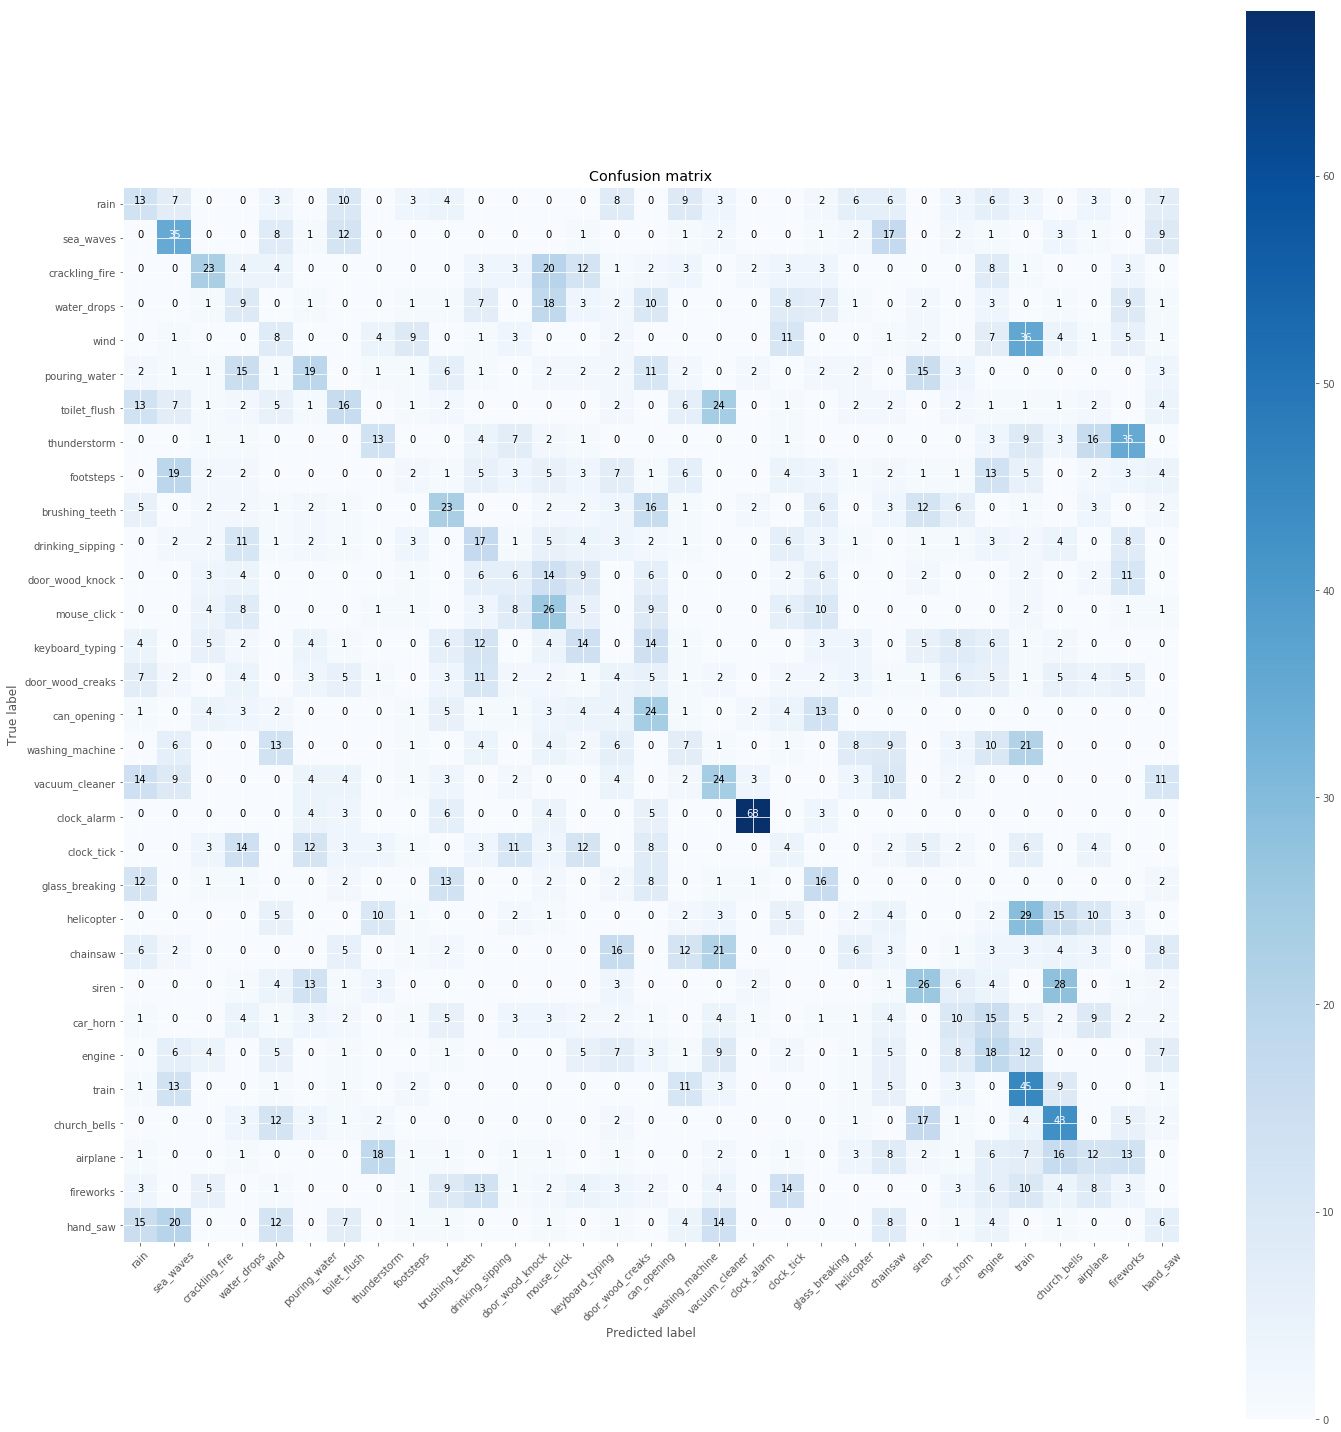

In [63]:
pred = inter.predict(new_dat)
print(metrics.accuracy_score(i_targ, pred))
cm = metrics.confusion_matrix(i_targ, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, names_i)
plt.show()